In [1]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguedashlineups
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import teamdashlineups
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.endpoints import leaguestandings
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import time

In [2]:
def LineupData(season,per):
    tempdf = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf1 = tempdf[['GROUP_ID','GP','PLUS_MINUS']].copy()
    
    print("done")
    return(tempdf1)

In [3]:
def PlayerData(season,per):
    tempdf1 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Advanced', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Usage', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Misc', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Scoring', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Defense', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf = pd.merge(tempdf1,tempdf2, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    print('done')
    return(tempdf)

In [4]:
#Returns dictionary of scores
def nMax(n,playerids,attributes):
    teamscore = 0
    #Loop through players in lineup
    teamAttr = defaultdict(list)
    for player in playerids:
        playerstats = dfPlayer.loc[dfPlayer['PLAYER_ID'] == int(player)]
            
        for attr in attributes:
            playerscore = playerstats.iloc[0][attr]
            teamAttr[attr].append(playerscore)

    rawAttr = defaultdict()
    for x in teamAttr:
        teamAttr[x].sort(reverse = True)
        teamAttr[x] = teamAttr[x][:n]
        rawAttr[x] = sum(teamAttr[x][:n])
    return(rawAttr)

In [5]:
def GetLineups(season):
    nba_teams = teams.get_teams()

    teamLineups = defaultdict(str)
    for team in nba_teams:
        teamid = team['id']
        teamdf = teamdashlineups.TeamDashLineups(team_id = teamid, season = season, per_mode_detailed = 'Totals').get_data_frames()[1]
        #print(teamdf.head())
        teamdf.sort_values('MIN',ascending = False)
        teamLineups[team['abbreviation']] = teamdf.iat[0,1].split("-")[1:-1]
        #print("done")
        #print(teamLineups)
        time.sleep(1)
    
    print("done")
    return(teamLineups)

In [9]:
def getPlayerInfo(df):
    nba_teams = teams.get_teams()
    tempdf = pd.DataFrame()

    for team in nba_teams:
        teamid = team['id']
        roster = commonteamroster.CommonTeamRoster(team_id = teamid,season = '2017-18').get_data_frames()[0]
        tempdf = tempdf.append(roster)

        time.sleep(1)

    newRoster = tempdf[['PLAYER_ID','HEIGHT','EXP']].copy()
    df = df.merge(newRoster,on='PLAYER_ID',how='left')
    
    for index, row in df.iterrows():
        if pd.isnull(row['HEIGHT']):
            df.at[index,'HEIGHT'] = 0   
        else:
            feet = row['HEIGHT'].split('-')[0]
            #print(feet)
            inches = row['HEIGHT'].split('-')[1]
            df.at[index,'HEIGHT'] = 12*int(feet) + int(inches)    
        exp = row['EXP']
        if exp == 'R' or pd.isnull(exp):
            df.at[index,'EXP'] = 0
        else:
            df.at[index,'EXP'] = int(exp)
    
    
    print("done")
    return(df)


In [17]:
def getGameLog(season):
    games = leaguegamelog.LeagueGameLog(season_all_time = season).get_data_frames()[0]
    games.drop_duplicates('GAME_ID',inplace = True)
    dummy = pd.get_dummies(games['WL'])
    games = pd.concat([games,dummy],axis = 1)
    
    return(games)

In [10]:
dfLineup = LineupData('2017-18','Per100Possessions')
dfPlayer = PlayerData('2017-18','Per100Possessions')
dfPlayer = getPlayerInfo(dfPlayer)
teamLineups = GetLineups('2017-18')
print(len(dfLineup))
print(len(dfPlayer))
print(len(teamLineups))
#print(list(dfPlayer.columns))
dfPlayer.head()

done
done
done
done
2000
540
30


In [12]:
#Set attributes
attributes = ['AST','OREB','DREB','BLK','FG_PCT','FG3_PCT','STL','TOV','OFF_RATING','DEF_RATING','PF','PTS','HEIGHT','EXP']

#rand = nMax(2,['2585', '201142', '201939', '202691', '203110'],attributes)
#print(rand)

In [13]:
masterVals = defaultdict(list)
N = 3
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes)
    
    #Get averages to normalize
    for key1, value1 in vals.items():
        masterVals[key1].append(value1)

#Get normalized coefficients
normalCoeffs = defaultdict(float)
L = 100
for x in masterVals:
        normalCoeffs[x] = (L/np.mean(masterVals[x]))

#Work with coefficients
#Offensive
normalCoeffs['AST'] = normalCoeffs['AST'] * 2
normalCoeffs['OREB'] = normalCoeffs['OREB'] * 2
normalCoeffs['FG_PCT'] = normalCoeffs['FG_PCT'] * 1
normalCoeffs['FG3_PCT'] = normalCoeffs['FG3_PCT'] * 1
normalCoeffs['TOV'] = normalCoeffs['TOV'] * -2
normalCoeffs['OFF_RATING'] = normalCoeffs['OFF_RATING'] * 2
normalCoeffs['PTS'] = normalCoeffs['PTS'] * 1

#Defensive
normalCoeffs['DREB'] = normalCoeffs['DREB'] * .5
normalCoeffs['STL'] = normalCoeffs['STL'] * 2
normalCoeffs['DEF_RATING'] = normalCoeffs['DEF_RATING'] * -.9
normalCoeffs['PF'] = normalCoeffs['PF'] * -2

#Attributes
normalCoeffs['HEIGHT'] = normalCoeffs['HEIGHT'] * 1
normalCoeffs['EXP'] = normalCoeffs['EXP'] * 2

#print(normalCoeffs)

#Calculate score for each team
teamRank = defaultdict(int)
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes)
    
    score = 0
    test = {}
    for key1,value1 in vals.items():
        score = score + (normalCoeffs[key1]*value1)
        test[key1] = normalCoeffs[key1]*value1
        
    teamRank[key] = score
    
print(teamRank)
print(test)

defaultdict(<class 'int'>, {'ATL': 968.7952259922299, 'BOS': 1017.4955171252519, 'CLE': 1103.6219361556432, 'NOP': 1196.9551976590772, 'CHI': 902.8483743341372, 'DAL': 988.8458706548171, 'DEN': 1080.7172772272897, 'GSW': 1214.7765037234153, 'HOU': 1294.911067592925, 'LAC': 1057.1442359955947, 'LAL': 893.1388885626856, 'MIA': 1127.2621129209163, 'MIL': 1045.3075947382658, 'MIN': 1146.7048541370289, 'BKN': 964.5132185041853, 'NYK': 1111.5869480685685, 'ORL': 930.7413496149316, 'IND': 1138.0531375672674, 'PHI': 1013.839113390303, 'PHX': 962.6846973528563, 'POR': 959.3068443347024, 'SAC': 870.3975800314718, 'SAS': 1235.9061331675605, 'OKC': 1277.5191174730908, 'TOR': 1088.3456238371202, 'UTA': 1119.1531578137692, 'MEM': 926.1726599941479, 'WAS': 1013.790622115958, 'DET': 1007.2774314628955, 'CHA': 1142.1877084518962})
{'AST': 188.83974140864242, 'OREB': 214.20071400237998, 'DREB': 52.594936708860764, 'BLK': 97.59876065065842, 'FG_PCT': 101.66197560648708, 'FG3_PCT': 97.73419978147102, 'STL

## Results for a Single Game

In [23]:
#First get log of all the games for the season
games = getGameLog('2017-18')
print("There are " + str(len(games)) + " in the season.")

#Add in Scores to games
for index, row in games.iterrows():
    home = row['MATCHUP'].split(' ')[0]
    away = row['MATCHUP'].split(' ')[2]
    games.at[index,'homeScore'] = teamRank[home]
    games.at[index,'awayScore'] = teamRank[away]
    games.at[index,'netScore'] = teamRank[home] - teamRank[away]
    
games.head()

There are 1230 in the season.


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,L,W,homeScore,awayScore,netScore
0,22017,1610612744,GSW,Golden State Warriors,0021700002,2017-10-17,GSW vs. HOU,L,240,43,...,17,25,121,-1,1,1,0,1214.776504,1294.911068,-80.134564
2,22017,1610612738,BOS,Boston Celtics,0021700001,2017-10-17,BOS @ CLE,L,240,36,...,12,24,99,-3,1,1,0,1017.495517,1103.621936,-86.126419
4,22017,1610612750,MIN,Minnesota Timberwolves,0021700011,2017-10-18,MIN @ SAS,L,240,37,...,13,16,99,-8,1,1,0,1146.704854,1235.906133,-89.201279
6,22017,1610612757,POR,Portland Trail Blazers,0021700012,2017-10-18,POR @ PHX,W,240,44,...,18,20,124,48,1,0,1,959.306844,962.684697,-3.377853
8,22017,1610612738,BOS,Boston Celtics,0021700007,2017-10-18,BOS vs. MIL,L,240,39,...,15,27,100,-8,1,1,0,1017.495517,1045.307595,-27.812078


In [32]:
#Run Regressions on results
exog = sm.add_constant(games['netScore'])

model1 = sm.OLS(games['PLUS_MINUS'],games['netScore']).fit()
model2 = sm.OLS(games['PLUS_MINUS'],exog).fit()
model3 = sm.OLS(games['W'],games['netScore']).fit()
model4 = sm.OLS(games['W'],exog).fit()
model5 = sm.Logit(games['W'],games['netScore']).fit()
model4.summary()

Optimization terminated successfully.
         Current function value: 43.234977
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     103.5
Date:                Wed, 27 Feb 2019   Prob (F-statistic):           2.11e-23
Time:                        12:01:50   Log-Likelihood:                -842.78
No. Observations:                1230   AIC:                             1690.
Df Residuals:                    1228   BIC:                             1700.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4923      0.014     35.934      0.000       0.465       0.519
netScore       0.0009   8.41e-05     10.175      0.000       0.001       0.001
==============================================================================
Omnibus:                     5906.736   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.171
Skew:                           0.022   Prob(JB):                     1.82e-32
Kurtosis:                       1.312   Cond. No.                         163.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Plus - Minus')

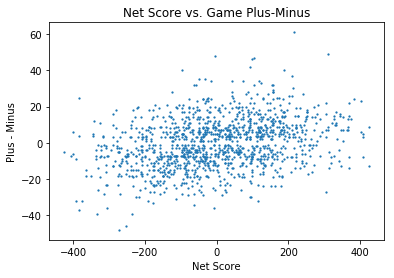

In [34]:
#Plot the results
plt.figure(1)
plt.scatter(games['netScore'],games['PLUS_MINUS'],s = 1.5)
plt.title("Net Score vs. Game Plus-Minus")
plt.xlabel("Net Score")
plt.ylabel("Plus - Minus")

In [37]:
#Examine the proportion of correctly predicted games in a sesaon
total = 0
correct = 0 
for index, row in games.iterrows():
    if row['W'] == 1 and row['netScore'] > 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 0 and row['netScore'] < 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 1 and row['netScore'] < 0:
        total = total + 1
    elif row['W'] == 0 and row['netScore'] > 0:
        total = total + 1
print(correct)
print(total)
print(correct/total)

759
1230
0.6170731707317073


## Results for a Season

In [38]:
#Get standings for the season
stand = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]
nba_teams = teams.get_teams()

lookup = {}
for team in nba_teams:
    teamid = team['id']
    lookup[team['nickname']] = team['abbreviation']

for index, row in stand.iterrows():
    name = row['TeamName']
    if name == 'Bobcats':
        abbrev = 'CHA'
    if name == 'SuperSonics':
        abbrev = 'OKC'
    else:
        abbrev = lookup[name]
    stand.at[index,'score'] = teamRank[abbrev]

#print(stand['WINS'])
stand.head()

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS,score
0,00,22017,1610612761,Toronto,Raptors,East,40-12,1,- e,Atlantic,...,None,None,None,None,4-2,9-5,11-3,41-16,18-7,1088.345624
1,00,22017,1610612745,Houston,Rockets,West,41-11,1,- w,Southwest,...,None,None,None,None,5-3,12-1,9-5,44-13,21-4,1294.911068
2,00,22017,1610612738,Boston,Celtics,East,33-19,2,- x,Atlantic,...,None,None,None,None,5-2,14-2,11-6,40-19,15-8,1017.495517
3,00,22017,1610612744,Golden State,Warriors,West,34-18,2,- p,Pacific,...,None,None,None,None,5-3,11-3,13-2,44-14,14-10,1214.776504
4,00,22017,1610612757,Portland,Trail Blazers,West,31-21,3,- nw,Northwest,...,None,None,None,None,4-3,9-6,5-8,32-26,17-7,959.306844


In [39]:
#Run Regressions on Results
model = sm.OLS(stand['WINS'],stand['score']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   WINS   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     550.3
Date:                Wed, 27 Feb 2019   Prob (F-statistic):           2.09e-20
Time:                        12:05:04   Log-Likelihood:                -110.29
No. Observations:                  30   AIC:                             222.6
Df Residuals:                      29   BIC:                             224.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          0.0391      0.002     23.459      0.000       0.036       0.042
==============================================================================
Omnibus:                        2.238   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.327   Jarque-Bera (JB):                1.198
Skew:                          -0.022   Prob(JB):                        0.549
Kurtosis:                       2.022   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Wins')

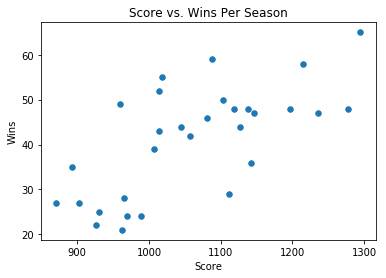

In [43]:
#Plot the results
plt.figure(1)
plt.scatter(stand['score'],stand['WINS'],s = 30)
plt.title("Score vs. Wins Per Season")
plt.xlabel("Score")
plt.ylabel("Wins")

In [718]:
#What to do 

#Look at All-Star break before and after
#Fix Score
#Categorize scores into offensive, defensive, and attributes

#Work on actual calcuations
#What to do from here? Are we happy with this? 
#Potentially add in clutch player 

#Beginning season prediction - player stats from year before and lineups from this year
#All star break predictions
#Actual what happened

#Look at N-Max for 1,2,3,4,5 - Done results are alright



In [719]:
for k,v in teamRank.items():
    #print(k)
    print(v)

11.543514591231334
8.141085135055912
9.060990008991432
11.67296925902408
9.479694205496218
9.770195080008383
11.88282860828431
9.365801074746836
10.096876571310847
11.743723914617298
8.747865464628427
12.606767773080472
11.57998704758378
9.185701505035553
11.414027834669387
12.367939258465668
10.095109471787193
11.101627267195314
10.385075569785936
10.366791986558724
10.688142293605488
9.260948677477717
12.066930452390174
12.085464471802627
10.675510215667675
11.181469743438507
12.337108437990116
10.451694748506553
8.731142317800765
9.913017013763302


In [720]:
12.499515474567378
12.606767773080472
12.94911068

12.94911068